# Fraud detection in procurement data (Prozorro)

## Exploratory Data Analysis (EDA)

### Labelled Monitorings Data

In [ ]:
!pip install ace_tools

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# all necessary imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import time

from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [7]:
labelled_data = pd.read_csv("/content/drive/MyDrive/ml_project/prozorro_labelled.csv")

In [8]:
labelled_data.head()

,Ідентифікатор тендера,...,Заголовки тендерів,Тип методу закупівлі,Очікувана вартість тендера,Статус тендера,Організатор,Ідентифікатор моніторингу,Дата початку моніторингу органом моніторингу,Статус усунення порушень замовником (загалом),"Є порушення, виявлені органом моніторингу",Дата оголошення тендера
0,UA-2024-07-26-006577-a,https://prozorro.gov.ua/tender/UA-2024-07-26-0...,Капітальний ремонт будівлі Стовп’язької загаль...,Відкриті торги з особливостями,43139872.0,Завершена закупівля,"Відділ освіти, культури, туризму, молоді та сп...",UA-M-2025-02-18-000074,2025-02-18,-,0,2024-07-26
1,UA-2024-08-15-001731-a,https://prozorro.gov.ua/tender/UA-2024-08-15-0...,Сміттєвоз бокового завантаження на шасі JАC N2...,Відкриті торги з особливостями,5468835.0,Завершена закупівля,"Комунальне підприємство ""Комунальник"" | 32572536",UA-M-2025-02-18-000045,2025-02-18,-,0,2024-08-15
2,UA-2024-09-23-014147-a,https://prozorro.gov.ua/tender/UA-2024-09-23-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,11935780.0,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000017,2025-02-18,-,0,2024-09-23
3,UA-2024-09-24-007689-a,https://prozorro.gov.ua/tender/UA-2024-09-24-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,12562969.2,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000009,2025-02-18,-,0,2024-09-24
4,UA-2024-09-24-008834-a,https://prozorro.gov.ua/tender/UA-2024-09-24-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,14063182.8,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000038,2025-02-18,-,0,2024-09-24


In [9]:
labelled_data.columns

Index(['Ідентифікатор тендера', '...', 'Заголовки тендерів',
       'Тип методу закупівлі', 'Очікувана вартість тендера', 'Статус тендера',
       'Організатор', 'Ідентифікатор моніторингу',
       'Дата початку моніторингу органом моніторингу',
       'Статус усунення порушень замовником (загалом)',
       'Є порушення, виявлені органом моніторингу', 'Дата оголошення тендера'],
      dtype='object')

In [10]:
labelled_data.shape

(63936, 12)

#### Renaming columns for better readability.

In [11]:
labelled_data.columns = [
    "tender_id", "tender_url", "tender_title", "procurement_method",
    "expected_value", "tender_status", "organizer", "monitoring_id",
    "monitoring_start_date", "violation_correction_status", "detected_violations",
    "tender_announcement_date"
]

#### Check missing values.

In [12]:
# labelled_data.drop(columns=["tender_url"], inplace=True)

# converting expected_value to numeric
labelled_data["expected_value"] = pd.to_numeric(labelled_data["expected_value"], errors='coerce')

# converting detected_violations to numeric (0 or 1)
labelled_data["detected_violations"] = pd.to_numeric(labelled_data["detected_violations"], errors='coerce')

missing_values = labelled_data.isnull().sum()
missing_values

,0
tender_id,0
tender_url,0
tender_title,1
procurement_method,0
expected_value,0
tender_status,0
organizer,0
monitoring_id,0
monitoring_start_date,0
violation_correction_status,0


#### Handling missing values.

In [13]:
# impute missing "expected_value" with median (to prevent outliers from influencing)
labelled_data["expected_value"] = labelled_data["expected_value"].fillna(labelled_data["expected_value"].median())

# assuming missing "detected_violations" means no violation (set to 0)
labelled_data["detected_violations"] = labelled_data["detected_violations"].fillna(0)
labelled_data = labelled_data.dropna(subset=["tender_title"])

missing_values_after = labelled_data.isnull().sum()
missing_values_after

,0
tender_id,0
tender_url,0
tender_title,0
procurement_method,0
expected_value,0
tender_status,0
organizer,0
monitoring_id,0
monitoring_start_date,0
violation_correction_status,0


#### Plots and observations

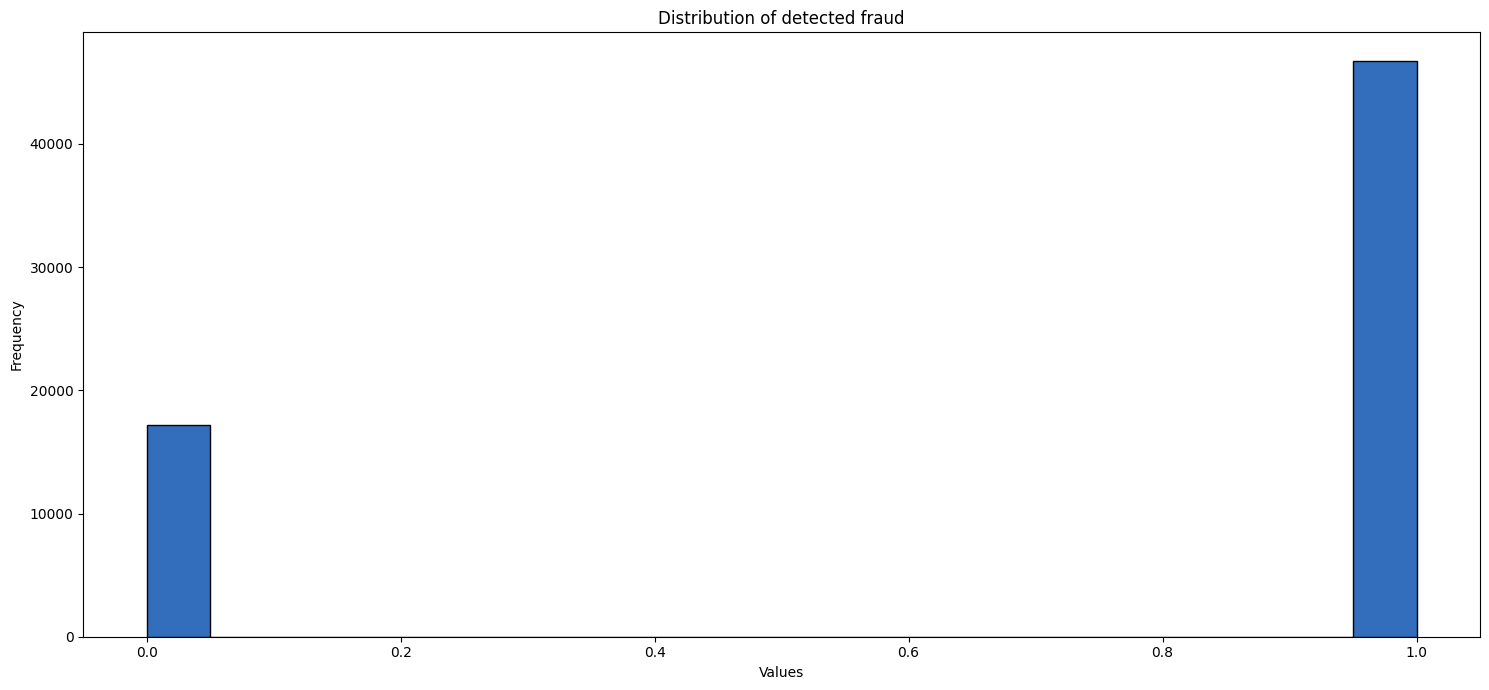

In [15]:
plt.figure(figsize=(15, 7))
sns.histplot(labelled_data['detected_violations'],
             color='#004aad',
             alpha=0.8)

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of detected fraud')
plt.tight_layout()
plt.show()

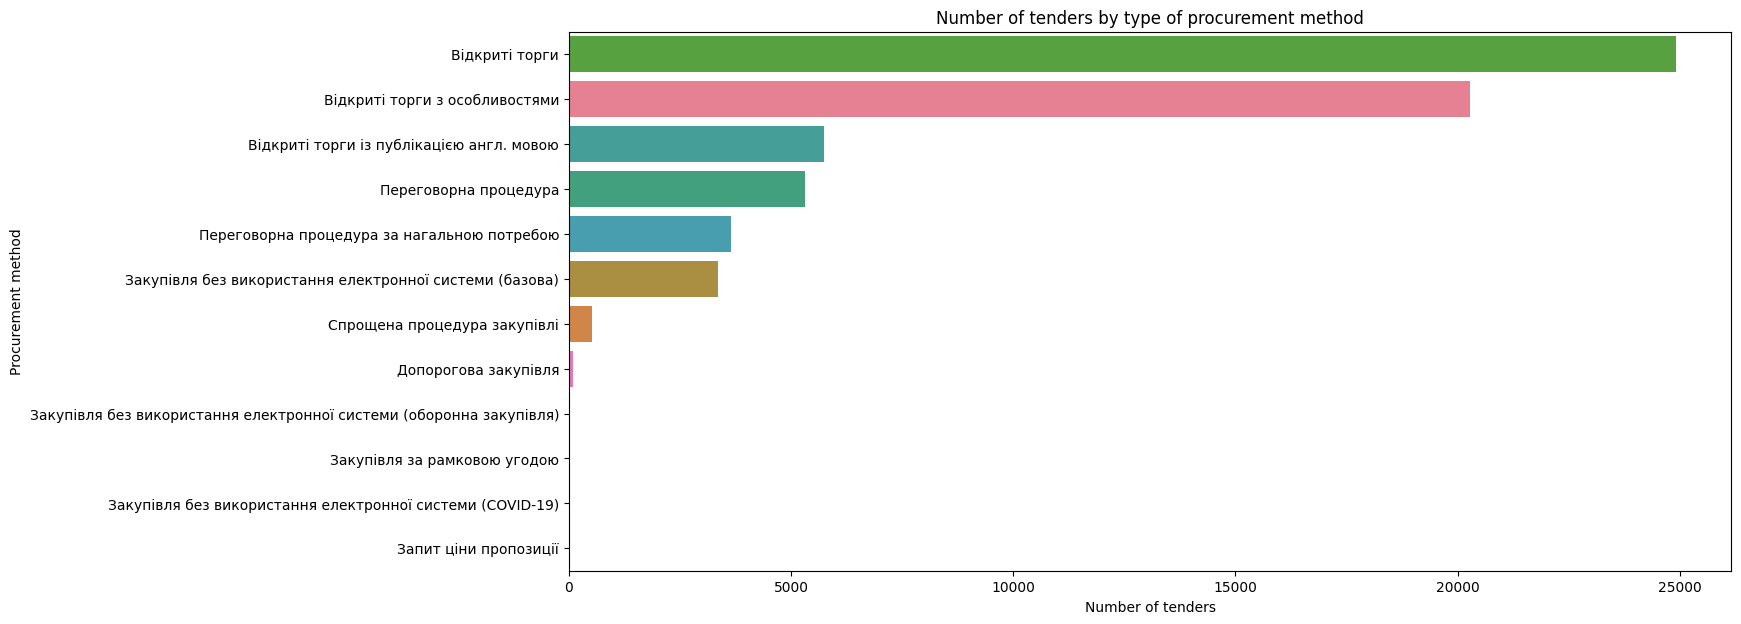

In [16]:
plt.figure(figsize=(15, 7))
sns.countplot(
    y=labelled_data['procurement_method'],
    order=labelled_data['procurement_method'].value_counts().index,
    hue=labelled_data['procurement_method'],
    palette='husl',
    legend=False
)
plt.xlabel('Number of tenders')
plt.ylabel('Procurement method')
plt.title('Number of tenders by type of procurement method')
plt.show()

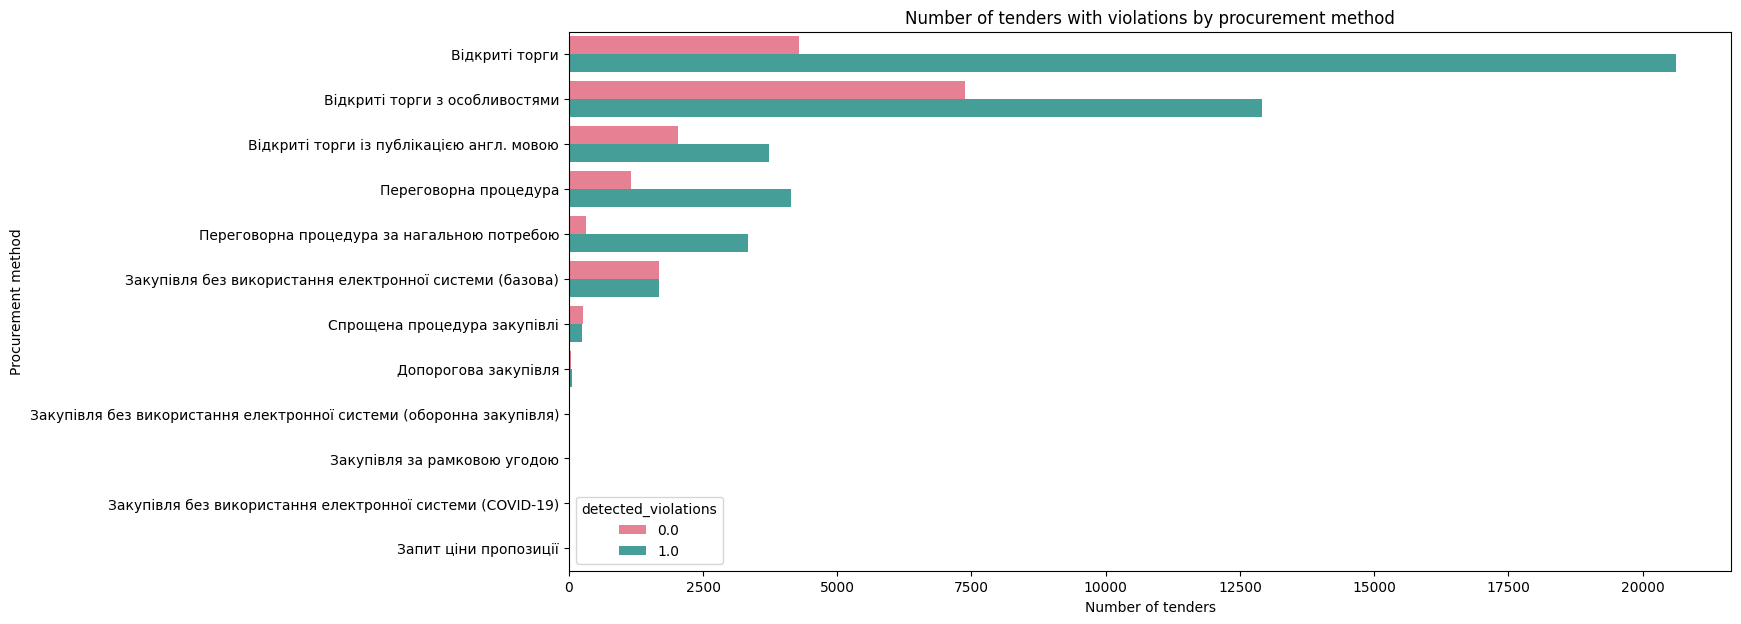

In [17]:
plt.figure(figsize=(15, 7))
sns.set_palette("husl")

ax = sns.countplot(
    data=labelled_data,
    y='procurement_method',
    hue='detected_violations',
    palette="husl",
    order=labelled_data['procurement_method'].value_counts().index
)

plt.xlabel('Number of tenders')
plt.ylabel('Procurement method')
plt.title('Number of tenders with violations by procurement method')

plt.show()

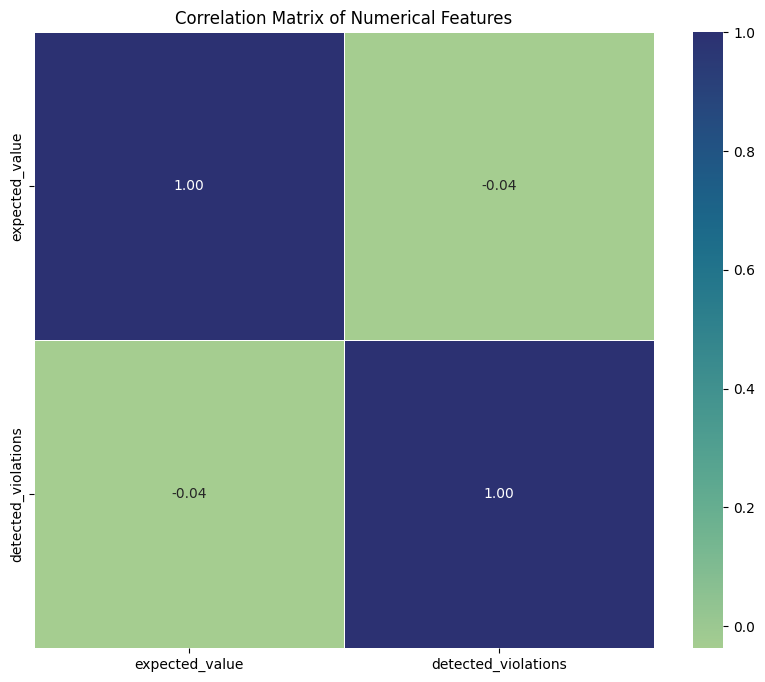

In [18]:
correlation_matrix = labelled_data.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="crest", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [19]:
labelled_data["monitoring_start_date"] = pd.to_datetime(labelled_data["monitoring_start_date"], errors='coerce')
labelled_data["tender_announcement_date"] = pd.to_datetime(labelled_data["tender_announcement_date"], errors='coerce')

In [20]:
# 1. Create a time gap feature between tender announcement and monitoring start date
labelled_data["time_gap_days"] = (labelled_data["monitoring_start_date"] - labelled_data["tender_announcement_date"]).dt.days

# 2. Categorize "expected_value" into bins
bins = [50000, 100000, 250000, 1000000, float('inf')]
labels = ["Low (50k-100k)", "Medium (100k-250k)", "High (250k-1M)", "Very High (1M+)"]
labelled_data["expected_value_category"] = pd.cut(labelled_data["expected_value"], bins=bins, labels=labels, right=True)

# 3. Count fraud occurrence by procurement method
fraud_by_procurement = labelled_data.groupby("procurement_method")["detected_violations"].mean().sort_values(ascending=False)

# 4. Count fraud occurrence by organizer (Top 10 organizers)
fraud_by_organizer = labelled_data.groupby("organizer")["detected_violations"].mean().sort_values(ascending=False).head(10)

# 5. Count fraud occurrence by expected value category
fraud_by_value_category = labelled_data.groupby("expected_value_category")["detected_violations"].mean().sort_values(ascending=False)

<ipython-input-20-66b5b3732ca6>:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_value_category = labelled_data.groupby("expected_value_category")["detected_violations"].mean().sort_values(ascending=False)


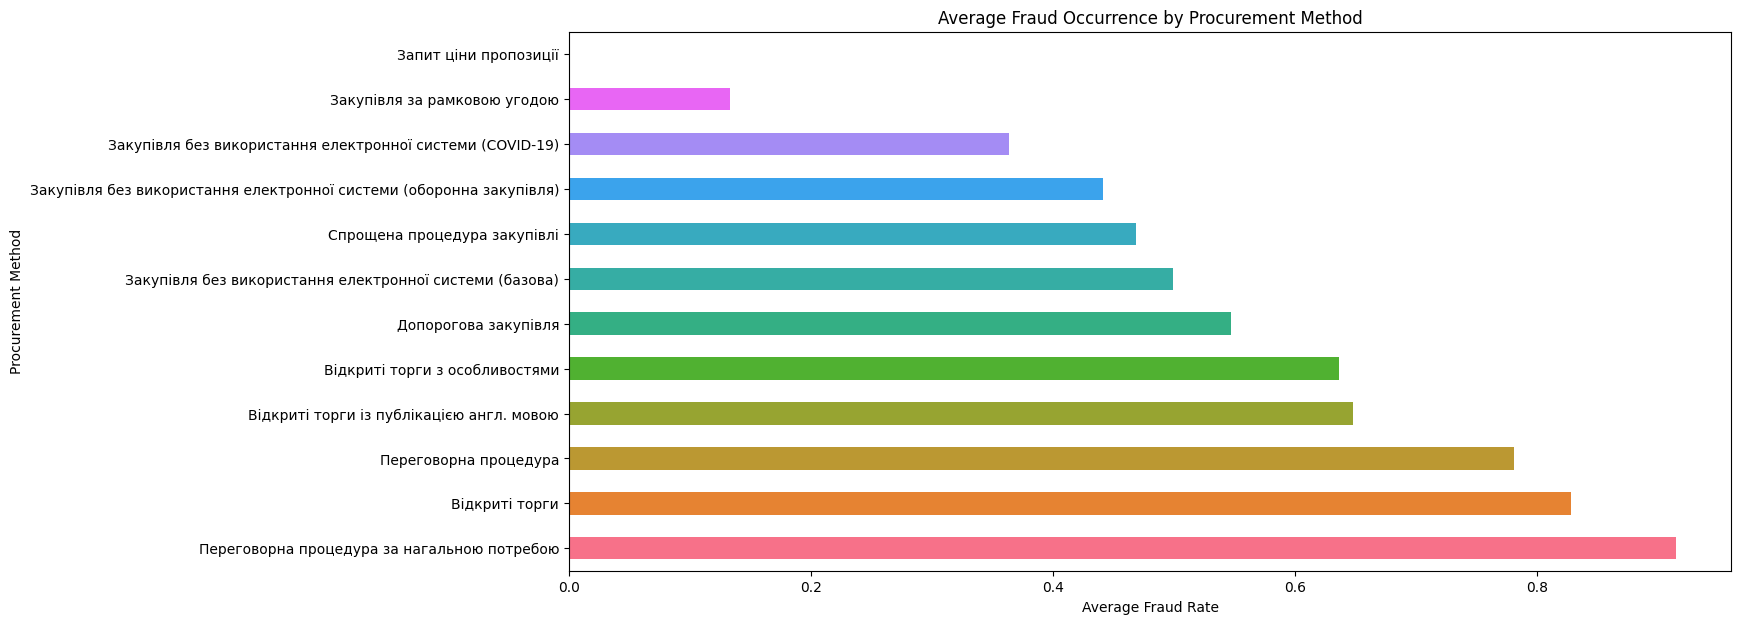

In [21]:
plt.figure(figsize=(15, 7))
fraud_by_procurement.plot(kind="barh", color=sns.color_palette("husl", len(fraud_by_procurement)))
plt.title("Average Fraud Occurrence by Procurement Method")
plt.xlabel("Average Fraud Rate")
plt.ylabel("Procurement Method")

plt.yticks(rotation=0)
plt.show()

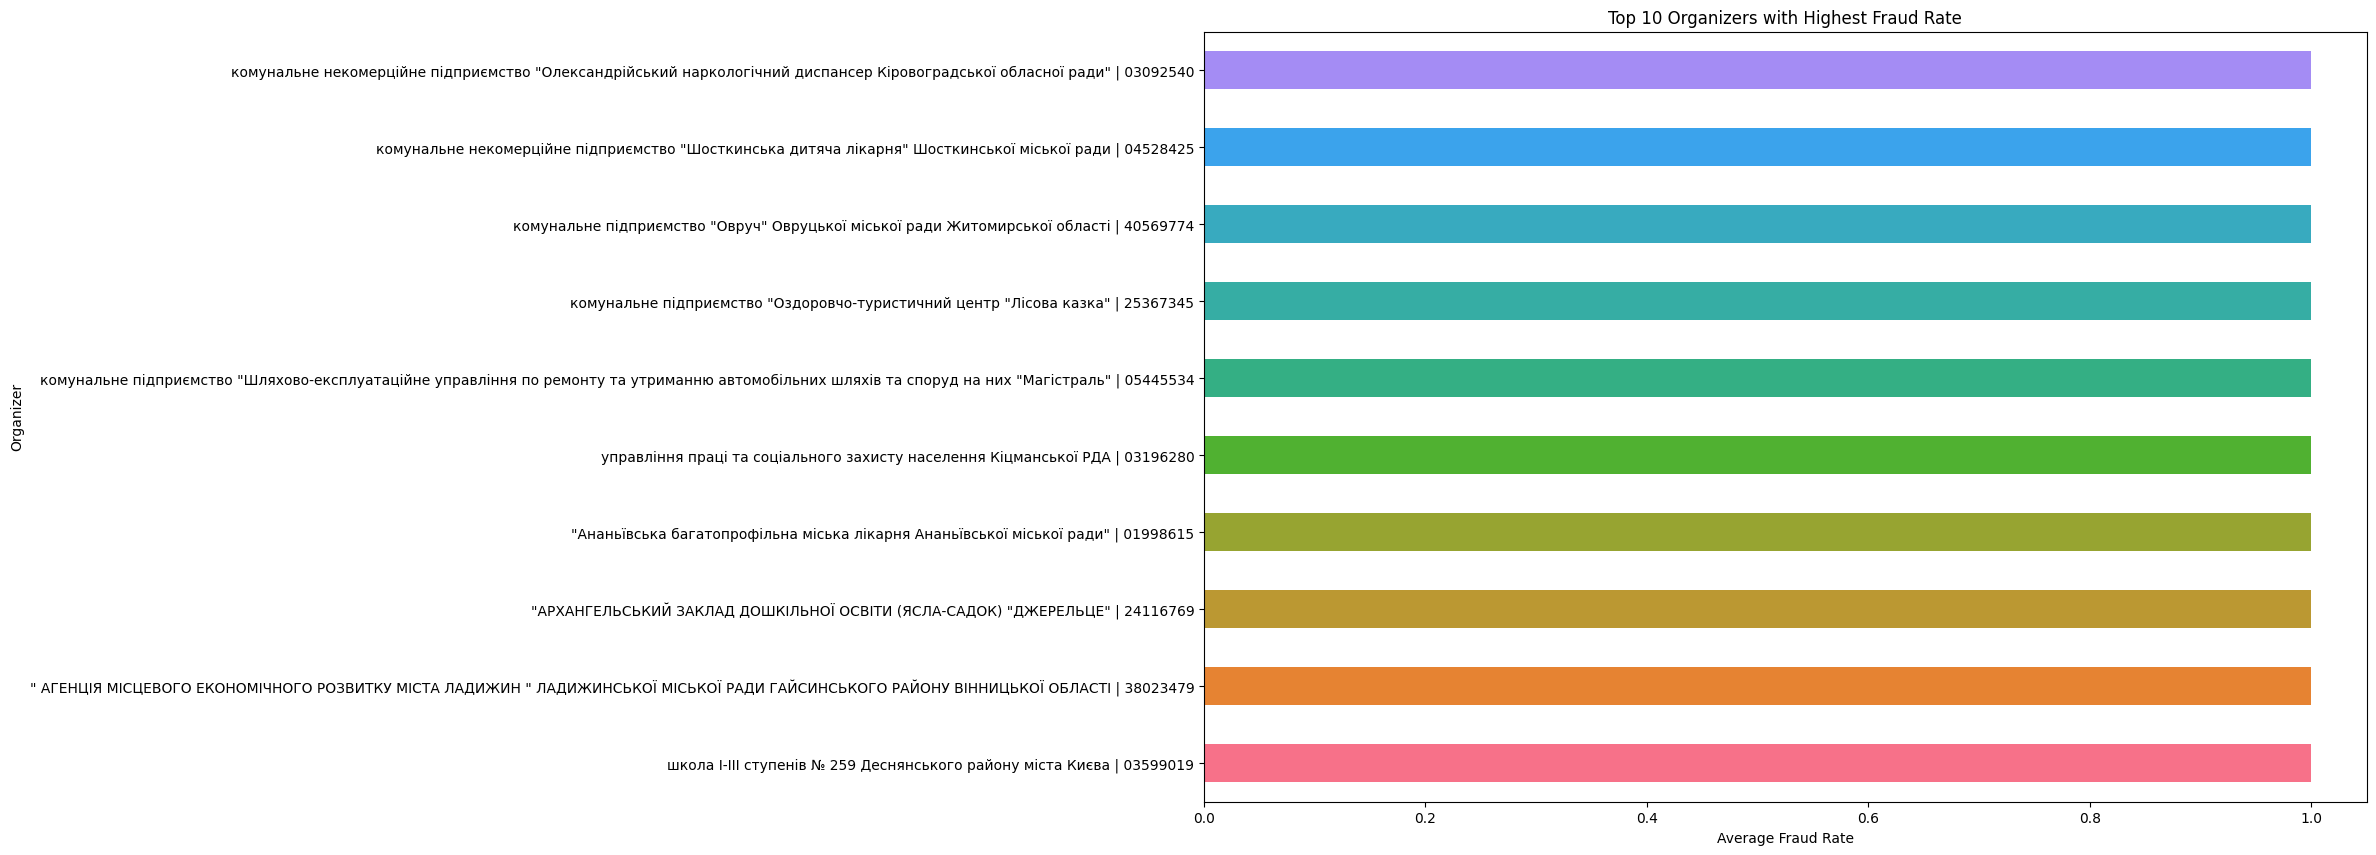

In [22]:
plt.figure(figsize=(15, 10))
fraud_by_organizer.plot(kind="barh", color=sns.color_palette("husl", len(fraud_by_procurement)))

plt.title("Top 10 Organizers with Highest Fraud Rate")
plt.xlabel("Average Fraud Rate")
plt.ylabel("Organizer")

plt.yticks(rotation=0)
plt.show()

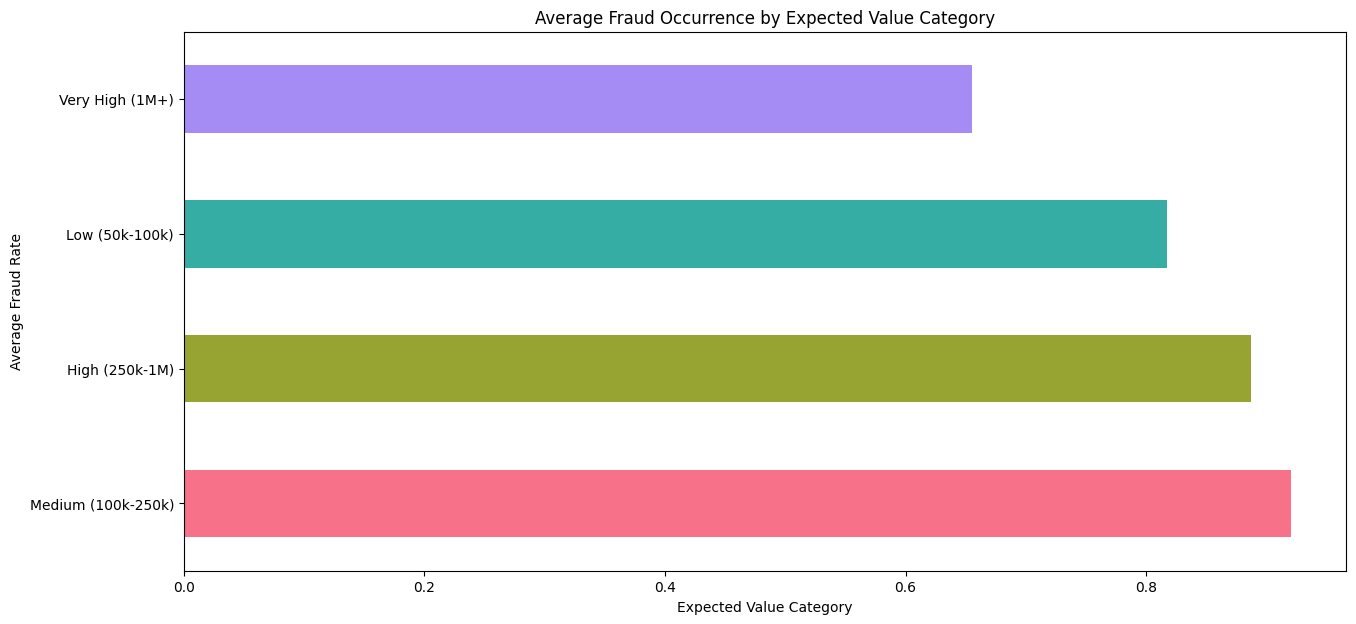

In [23]:
plt.figure(figsize=(15, 7))
fraud_by_value_category.plot(kind="barh", color=sns.color_palette("husl", len(fraud_by_value_category)))

plt.title("Average Fraud Occurrence by Expected Value Category")
plt.xlabel("Expected Value Category")
plt.ylabel("Average Fraud Rate")

plt.xticks(rotation=0)
plt.show()

### Unlabelled Monitorings Data (Main)

In [24]:
full_data = pd.read_csv("/content/drive/MyDrive/ml_project/prozorro_full.csv")

In [25]:
full_data.head()


,tender_id,tender,expected_value,VAT,procurement_procedure,procedure_status,tender_status,announcement_date,organizer,winner,...,price_per_unit,measurement,cpv_classification,number_of_participants,number_of_disqualifications,number_of_questions,number_of_requirements,number_of_complaints,number_of_monitorings,expected_value_category
0,UA-2019-02-28-002408-a-L1,Послуги з повірки вимірювальної техніки,121055.96,без ПДВ,Закупівля без використання електронної системи...,Завершена закупівля,Завершено лот закупівлі,2019-02-28,"КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО ""ТРЕТЯ ЧЕ...","ДЕРЖАВНЕ ПІДПРИЄМСТВО ""ЧЕРКАСЬКИЙ НАУКОВО-ВИРО...",...,121055.96,послуга,71630000-3 Послуги з технічного огляду та випр...,1,0,0,0,0,0,Medium (100k-250k)
1,UA-2019-02-28-002407-a-L1,УПГГК 19Т-021: 15510000-6–Молоко та вершки.,1913450.00,з ПДВ,Допорогова закупівля,Завершена закупівля,Завершено лот закупівлі,2019-02-28,"Укргазвидобування"" в особі філії ""Управління з...",ФОП Сергієнко Володимир Іванович | 3019512776,...,20.40,кілограм,15510000-6 Молоко та вершки,5,0,1,0,0,0,Very High (1M+)
2,UA-2019-02-28-002406-a-L1,Природний газ,176343.03,з ПДВ,Закупівля без використання електронної системи...,Завершена закупівля,Завершено лот закупівлі,2019-02-28,Відокремлений структурний підрозділ «Тернопіль...,"ДОЧІРНЄ ПІДПРИЄМСТВО ""ГАЗПОСТАЧ"" ТОВАРИСТВА З ...",...,11.79,метр кубічний,09120000-6 Газове паливо,1,0,0,0,0,0,Medium (100k-250k)
3,UA-2019-02-28-002404-a-L1,код CPV за ДК 021:2015 45110000-1: Руйнування...,198000.00,без ПДВ,Закупівля без використання електронної системи...,Завершена закупівля,Завершено лот закупівлі,2019-02-28,"КОМУНАЛЬНЕ ПІДПРИЄМСТВО ""ПЕРСПЕКТИВА"" КРАСНОСІ...",ТОВ СТАНІ МАГНУМ | 22445949,...,198000.00,послуга,45110000-1 Руйнування та знесення будівель і з...,1,0,0,0,0,0,Medium (100k-250k)
4,UA-2019-02-28-002403-a-L1,Картопля (Код за ДК 021:2015 - 03210000-6 Зерн...,980000.00,з ПДВ,Відкриті торги,Завершена закупівля,Завершено лот закупівлі,2019-02-28,Національна академія внутрішніх справ | 08751177,"ФЕРМЕРСЬКЕ ГОСПОДАРСТВО ""БІАТРІС"" | 34438448",...,9.36,кілограм,03210000-6 Зернові культури та картопля,2,0,0,0,0,0,High (250k-1M)


In [26]:
count = (full_data['number_of_participants'] == 0).sum()

In [27]:
unique_procedure = full_data['procurement_procedure'].unique()
unique_status = full_data['procedure_status'].unique()
unique_tender_status = full_data['tender_status'].unique()

for val in unique_procedure:
  print(val)

Закупівля без використання електронної системи (базова)
Допорогова закупівля
Відкриті торги
Переговорна процедура за нагальною потребою
Відкриті торги із публікацією англ. мовою
Переговорна процедура
Переговорна процедура (для потреб оборони)
Конкурентний діалог з публікацією англійською мовою: етап 2
Пряма закупівля через е-каталог
Закупівля за рамковою угодою
Конкурентний діалог: етап 2
Спрощена процедура закупівлі
Закупівля без використання електронної системи (COVID-19)
Запит ціни пропозиції
Відкриті торги з особливостями
Закупівля без використання електронної системи (оборонна закупівля)


In [28]:
print(unique_status)

['Завершена закупівля' 'Відмінена закупівля' 'Закупівля не відбулась'
 'Пропозиції розглянуто' 'Активна закупівля' 'Прекваліфікація'
 'Кваліфікація переможця' 'Очікування пропозицій'
 'Прекваліфікація (період оскаржень)']


In [29]:
print(unique_tender_status)

['Завершено лот закупівлі' 'Скасовано лот закупівлі'
 'Неуспішний лот закупівлі' 'Активний лот закупівлі']


In [30]:
full_data.columns

Index(['tender_id', 'tender', 'expected_value', 'VAT', 'procurement_procedure',
       'procedure_status', 'tender_status', 'announcement_date', 'organizer',
       'winner', 'duration', 'price_per_unit', 'measurement',
       'cpv_classification', 'number_of_participants',
       'number_of_disqualifications', 'number_of_questions',
       'number_of_requirements', 'number_of_complaints',
       'number_of_monitorings', 'expected_value_category'],
      dtype='object')

In [31]:
full_data.shape

(2615908, 21)

#### Renaming columns for better readability.

In [33]:
full_data.columns

Index(['tender_id', 'tender', 'expected_value', 'VAT', 'procurement_procedure',
       'procedure_status', 'tender_status', 'announcement_date', 'organizer',
       'winner', 'duration', 'price_per_unit', 'measurement',
       'cpv_classification', 'number_of_participants',
       'number_of_disqualifications', 'number_of_questions',
       'number_of_requirements', 'number_of_complaints',
       'number_of_monitorings', 'expected_value_category'],
      dtype='object')

In [34]:
full_data.columns = [
    "tender_id", "tender", "expected_value", "VAT", "procurement_procedure",
    "procedure_status", "tender_status", "announcement_date",
    "organizer", "winner", "duration", "price_per_unit", "measurement", "cpv_classification",
    "number_of_participants", "number_of_disqualifications", "number_of_questions",
    "number_of_requirements", "number_of_complaints", "number_of_monitorings", "expected_value_category"
]

In [35]:
full_data.to_csv("/content/drive/MyDrive/prozorro_full.csv", index=False)

#### Check missing values.

In [38]:
# full_data.drop(columns=["tender_url"], inplace=True)

# converting expected_value to numeric
full_data["expected_value"] = (
    full_data["expected_value"]
    .astype(str)
    .str.replace("\xa0", "", regex=True)
    .str.replace(" ", "", regex=True)
    .str.replace(",", ".", regex=False)
)
full_data["expected_value"] = pd.to_numeric(full_data["expected_value"], errors='coerce')

# assuming '-' in price_per_unit means that there are no units, some kind of service
full_data["price_per_unit"] = full_data.apply(
    lambda row: row["expected_value"] if row["price_per_unit"] == '-' else row["price_per_unit"],
    axis=1
)
full_data = full_data.dropna(subset=['tender'])

missing_values = full_data.isnull().sum()
missing_values

,0
tender_id,0
tender,0
expected_value,0
VAT,0
procurement_procedure,0
procedure_status,0
tender_status,0
announcement_date,0
organizer,0
winner,0


#### Plots and observations

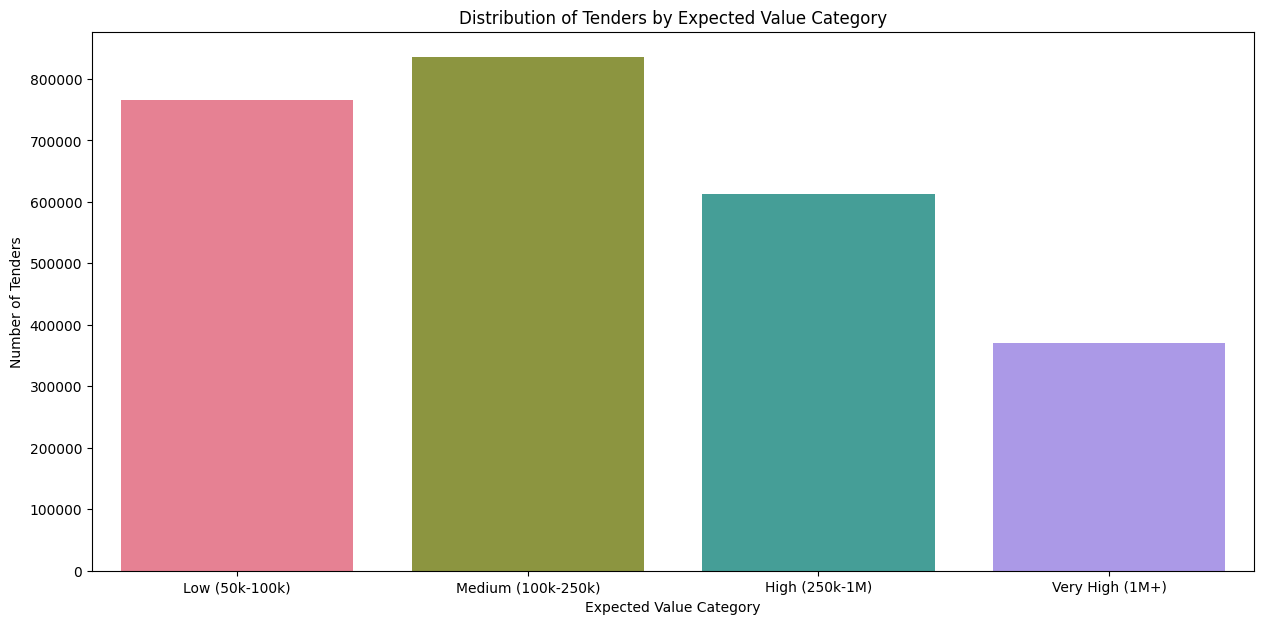

In [39]:
bins = [50000, 100000, 250000, 1000000, float('inf')]
labels = ["Low (50k-100k)", "Medium (100k-250k)", "High (250k-1M)", "Very High (1M+)"]
full_data["expected_value_category"] = pd.cut(full_data["expected_value"], bins=bins, labels=labels, right=True)

plt.figure(figsize=(15, 7))
sns.countplot(
    data=full_data,
    x="expected_value_category",
    hue="expected_value_category",
    palette="husl",
    legend=False
)

plt.title("Distribution of Tenders by Expected Value Category")
plt.xlabel("Expected Value Category")
plt.ylabel("Number of Tenders")
plt.show()

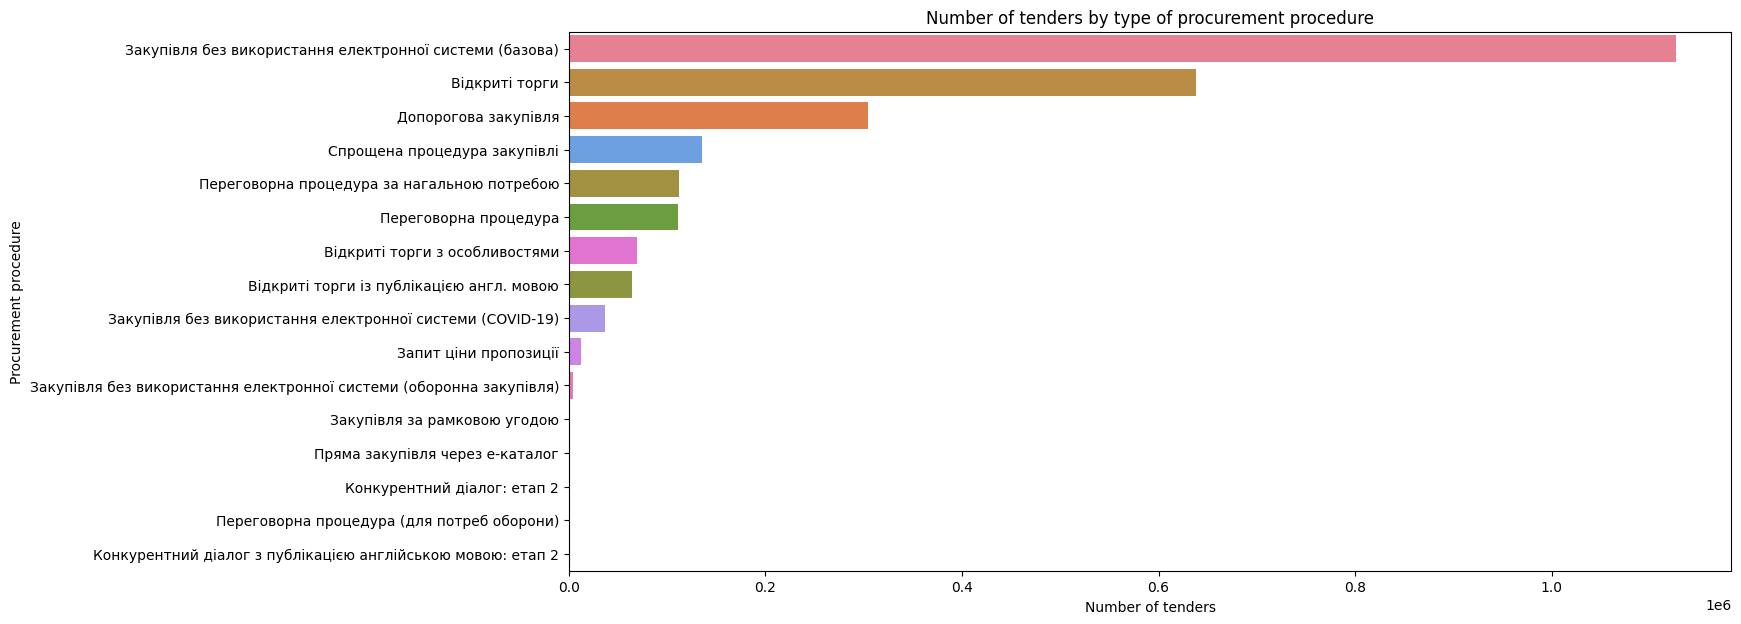

In [40]:
plt.figure(figsize=(15, 7))
sns.countplot(
    y=full_data['procurement_procedure'],
    order=full_data['procurement_procedure'].value_counts().index,
    hue=full_data['procurement_procedure'],
    palette='husl',
    legend=False
)
plt.xlabel('Number of tenders')
plt.ylabel('Procurement procedure')
plt.title('Number of tenders by type of procurement procedure')
plt.show()

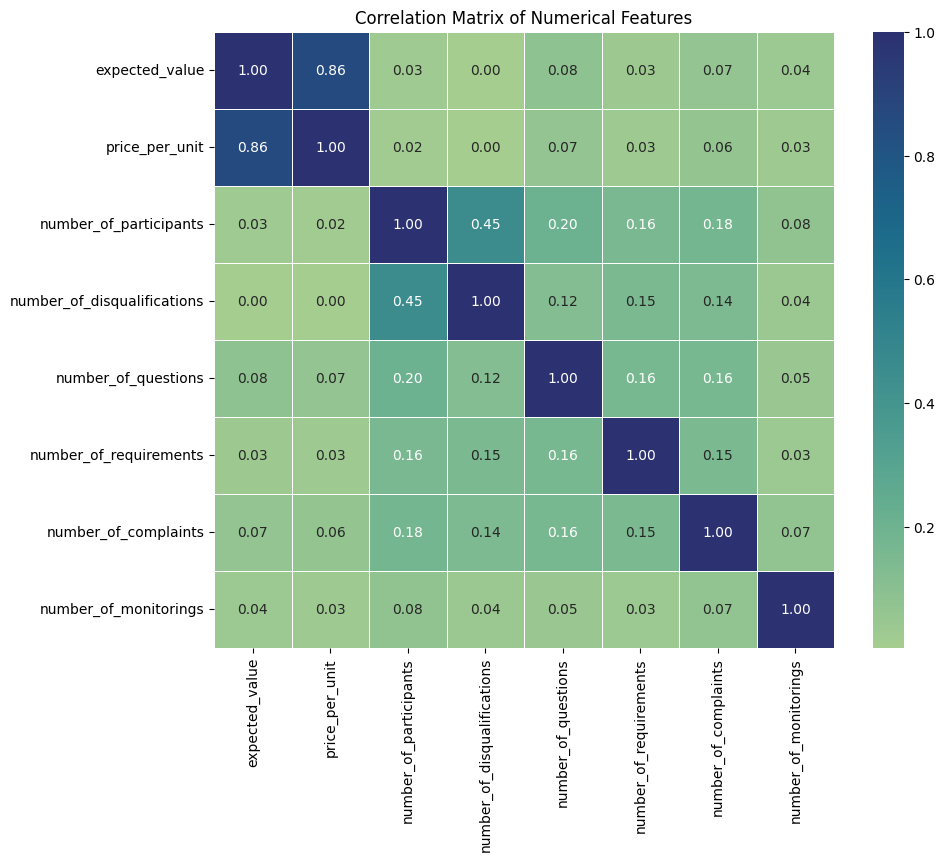

In [41]:
correlation_matrix = full_data.select_dtypes(include=['number']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="crest", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

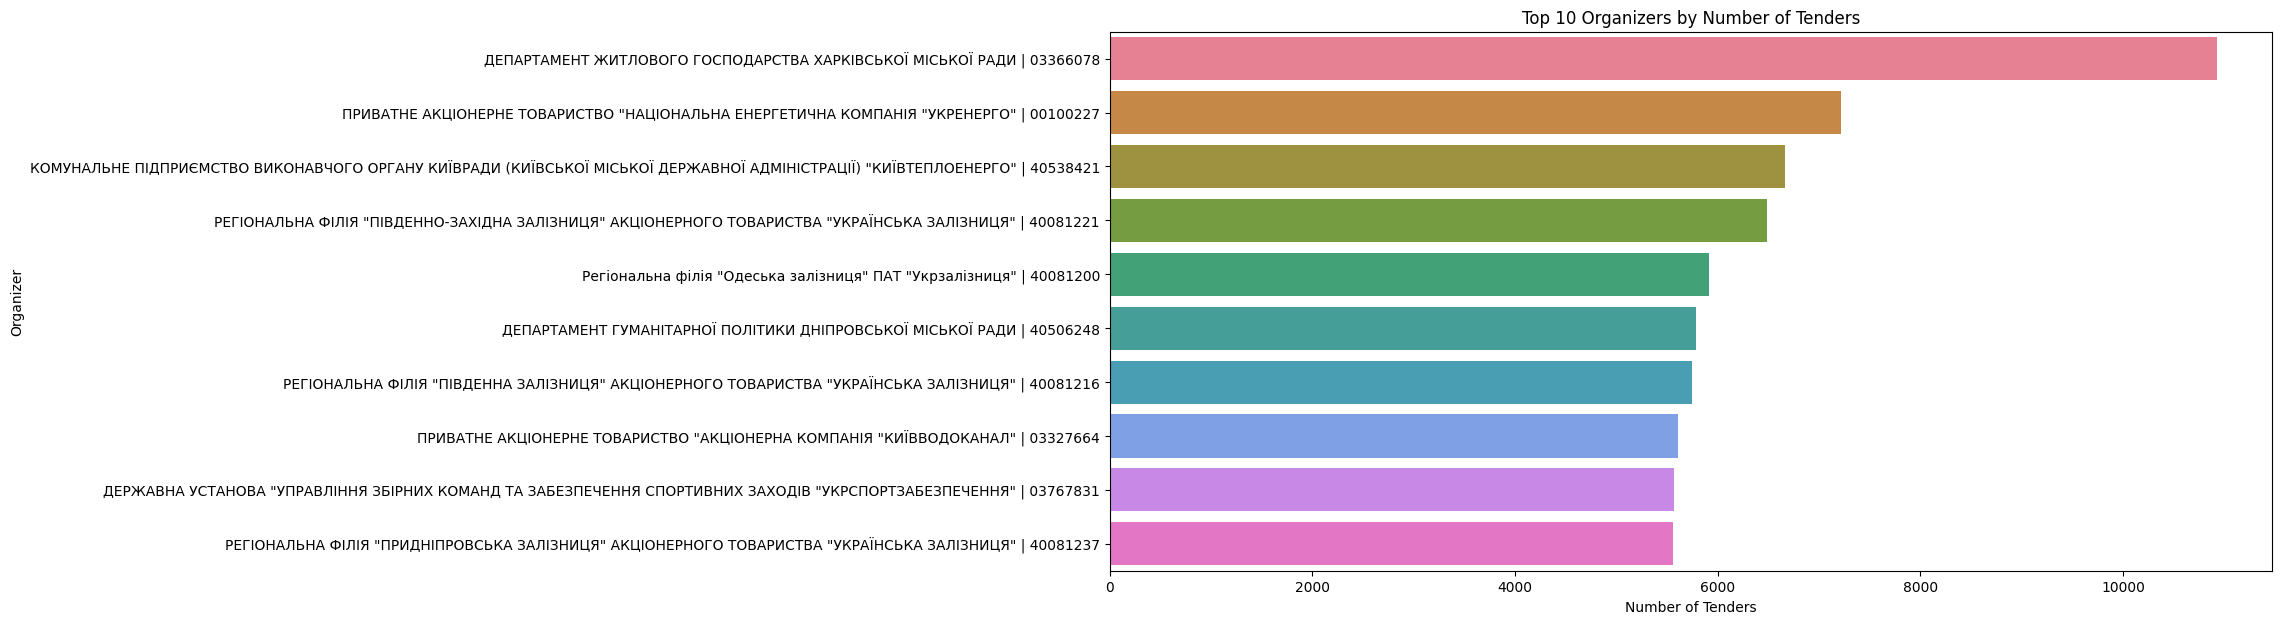

In [42]:
top_organizers = full_data['organizer'].value_counts().head(10)

plt.figure(figsize=(15, 7))
sns.barplot(
    y=top_organizers.index,
    x=top_organizers.values,
    hue=top_organizers.index,
    palette='husl',
    legend=False
)
plt.title('Top 10 Organizers by Number of Tenders')
plt.xlabel('Number of Tenders')
plt.ylabel('Organizer')
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


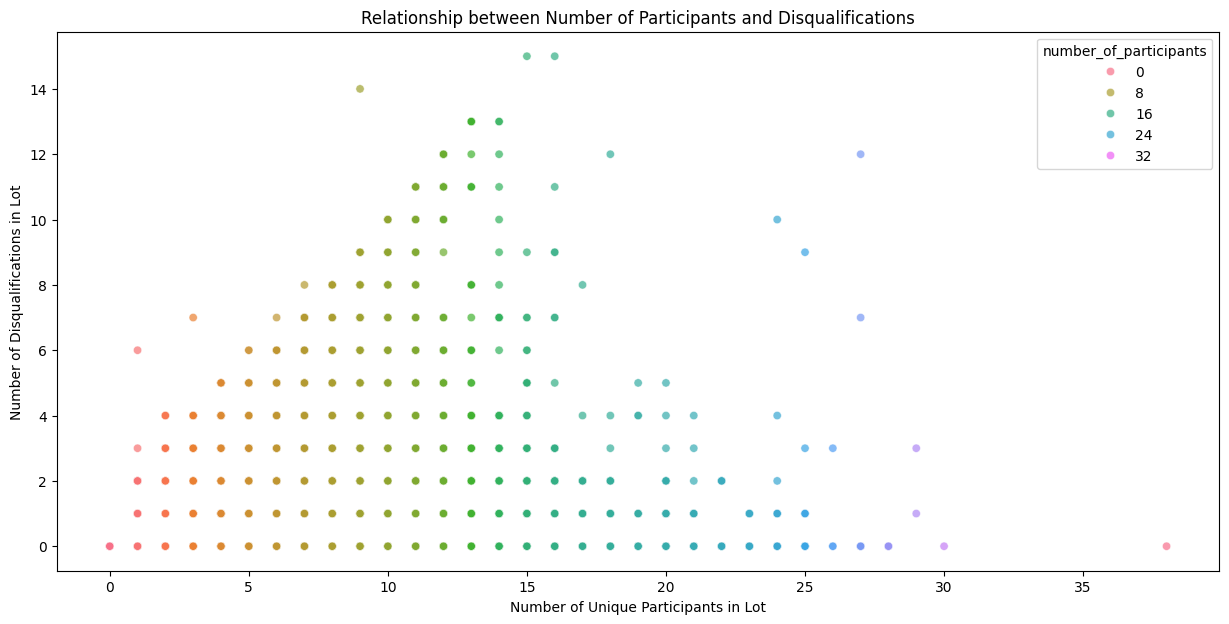

In [43]:
plt.figure(figsize=(15, 7))
sns.scatterplot(
    data=full_data,
    x='number_of_participants',
    y='number_of_disqualifications',
    alpha=0.7,
    hue='number_of_participants',
    palette='husl',
)
plt.title('Relationship between Number of Participants and Disqualifications')
plt.xlabel('Number of Unique Participants in Lot')
plt.ylabel('Number of Disqualifications in Lot')
plt.show()

## Data scraping

In [ ]:
def fetch_data(offset=None):
    if offset is not None:
        url = f"https://public.api.openprocurement.org/api/2.5/tenders?offset={offset}"
    else:
        url = f"https://public.api.openprocurement.org/api/2.5/tenders"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        return None

def process_data():
    offset = None
    all_tenders = []
    while True:
        data = fetch_data(offset)
        if not data or "data" not in data:
            break

        all_tenders.extend(data["data"])

        next_page = data["next_page"]
        if next_page:
            offset = next_page["offset"]
        else:
            break

    return all_tenders


def get_tender_details(tender_id):
    url = f"https://public.api.openprocurement.org/api/2.5/tenders/{tender_id}"
    response = requests.get(url)

    if response.status_code == 200:
        return response.json().get("data", {})
    else:
        print(f"Error fetching tender {tender_id}: {response.status_code}")
        return {}


In [ ]:
tenders = process_data()

In [ ]:
tender_ids = [tender["id"] for tender in tenders]

tender_details_list = []
for tender_id in tqdm(tender_ids, desc="Processing tenders", unit="tender"):
    details = get_tender_details(tender_id)
    if details:
        classification = details["items"][0]["classification"]
        tender_details_list.append({
            "id": tender_id,
            "tenderID": details.get("tenderID"),
            "title": details.get("title"),
            "status": details.get("status"),
            "description": details.get("description"),
            "procurementMethod": details.get("procurementMethod"),
            "procurementMethodType": details.get("procurementMethodType"),
            "submissionMethod": details.get("submissionMethod"),
            "tenderPeriod_start": details.get("tenderPeriod", {}).get("startDate"),
            "tenderPeriod_end": details.get("tenderPeriod", {}).get("endDate"),
            "amount": details.get("value", {}).get("amount"),
            "currency": details.get("value", {}).get("currency"),
            "procuringEntity": details.get("procuringEntity", {}).get("identifier", {}).get("legalName"),
            "cpv_classification": f"{classification.get('id', '')} {classification.get('description', '')}"
        })

Processing tenders: 100%|██████████| 100/100 [00:55<00:00,  1.79tender/s]


In [ ]:
df = pd.DataFrame(tender_details_list)
df.to_csv("tenders.csv", index=False, encoding="utf-8")

In [ ]:
labelled_data.head()

,tender_id,tender_url,tender_title,procurement_method,expected_value,tender_status,organizer,monitoring_id,monitoring_start_date,violation_correction_status,detected_violations,tender_announcement_date
0,UA-2024-07-26-006577-a,https://prozorro.gov.ua/tender/UA-2024-07-26-0...,Капітальний ремонт будівлі Стовп’язької загаль...,Відкриті торги з особливостями,43139872.0,Завершена закупівля,"Відділ освіти, культури, туризму, молоді та сп...",UA-M-2025-02-18-000074,2025-02-18,-,0,2024-07-26
1,UA-2024-08-15-001731-a,https://prozorro.gov.ua/tender/UA-2024-08-15-0...,Сміттєвоз бокового завантаження на шасі JАC N2...,Відкриті торги з особливостями,5468835.0,Завершена закупівля,"Комунальне підприємство ""Комунальник"" | 32572536",UA-M-2025-02-18-000045,2025-02-18,-,0,2024-08-15
2,UA-2024-09-23-014147-a,https://prozorro.gov.ua/tender/UA-2024-09-23-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,11935780.0,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000017,2025-02-18,-,0,2024-09-23
3,UA-2024-09-24-007689-a,https://prozorro.gov.ua/tender/UA-2024-09-24-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,12562969.2,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000009,2025-02-18,-,0,2024-09-24
4,UA-2024-09-24-008834-a,https://prozorro.gov.ua/tender/UA-2024-09-24-0...,Реконструкція приміщень харчоблоку та будівлі ...,Відкриті торги з особливостями,14063182.8,Завершена закупівля,ДЕПАРТАМЕНТ ГУМАНІТАРНОЇ ПОЛІТИКИ ДНІПРОВСЬКОЇ...,UA-M-2025-02-18-000038,2025-02-18,-,0,2024-09-24


In [ ]:
tender_id = "09076ffc415e4d57ad7046aacc91b6e1"
tender_info = get_tender_details(tender_id)

In [ ]:
tender_info

{'procurementMethod': 'open',
 'tenderPeriod': {'startDate': '2015-02-20T10:00:00+00:00',
  'endDate': '2015-02-23T10:00:00+00:00'},
 'description': 'Сіль технічна, помол 3, з додаванням антизлежувача, фасування в поліпропіленові мішки по 50кг.\nВідповідність вимог ДСТУ 4246:2003\nУмови поставки - самовивозом зі складу постачальника в межах м. Києва у відповідності до заявок замовника \nУмови оплати - оплата по факту поставки',
 'title': 'Сіль технічна',
 'minimalStep': {'currency': 'UAH',
  'amount': 500.0,
  'valueAddedTaxIncluded': True},
 'items': [{'unit': {'code': 'TNE', 'name': 'tonne (metric ton)'},
   'additionalClassifications': [{'scheme': 'ДКПП',
     'id': '08.93.1',
     'description': 'Сіль і чистий хлорид натрію; вода морська та сольові розчини'}],
   'description': 'Сіль технічна, помол 3, з додаванням антизлежувача, фасування в поліпропіленові мішки по 50кг.\nВідповідність вимог ДСТУ 4246:2003',
   'classification': {'scheme': 'CPV',
    'description': "Сіль кам'яна\x